# Binary Classification (Cat vs. Dog) with N11 Model 

## Background
Binary classification in the context of images, is the process of teaching a model to categorize a given image into one of two possible classes. 
We need to classify images to automate tasks that require visual understanding, enabling computers to interpret and make decisions based on the content of a picture.
This ability to automatically categorize images unlocks countless applications across various industries, from healthcare to transportation.

- Classify a skin lesion as either benign or malignant (cancerous) from a photograph, assisting dermatologists in early cancer detection. 
- An autonomous vehicle needs to classify objects as pedestrians or other objects.
- Classify different types of crops from an aerial photo, assess plant health by identifying diseased vs. healthy crops.
- Unlock your smartphone with your face is a process to identify authorized personnel vs. unauthorized intruders.

## Objectives:
- Practice neural network model with a hidden layer.
- Review binary classification.
- Get started using [PyTorch](https://pytorch.org/).

## Exercises:
1. $\color{violet}{\textbf{(20\%) Data Preprocessing}}$
2. $\color{violet}{\textbf{(5\%) Logistic Regression Model}}$
3. $\color{violet}{\textbf{(5\%) Cross Entropy Loss}}$
4. $\color{violet}{\textbf{(40\%) Gradient Descent Optimization}}$
5. $\color{violet}{\textbf{(20\%) Evaluation on Test Dataset}}$
6. $\color{violet}{\textbf{(10\%) Test Model with New Image}}$




## 1. Dataset Preparation with PyTorch

### 1.1 Create Annotation Files
Data is not always stored in NumPy arrays. Most cases, you will have to organize and annotate the raw data stored in your hard drive. For image data, you want it to be organized as the following way.
``` console
root/dog/xxx.jpg
root/dog/xxy.jpg
root/dog/xxz.jpg

root/cat/123.jpg
root/cat/456.jpg
root/cat/789.jpg
```
To grab image information and store them in an comma-seperated values (CSV) file:
1. Visit the data directory, grab all images' paths and corresponding categories.
2. Save the paths and categories of images in an `.csv` file 

In [1]:
import os
from glob import glob
import pandas as pd
from pathlib import Path

# Locate train and validation directories
root_dir = "./dataset"  # locate dataset directory from this repo in the whole system
# train_dir = os.path.join(root_dir, "training")
# test_dir = os.path.join(root_dir, "validation")
train_cat_dir = Path(root_dir) / "training" / "cats"
train_dog_dir = Path(root_dir) / "training" / "dogs"
val_cat_dir = Path(root_dir) / "validation" / "cats"
val_dog_dir = Path(root_dir) / "validation" / "dogs"

# Glob training files
train_cat_files = list(train_cat_dir.glob("**/*.jpg"))
train_dog_files = list(train_dog_dir.glob("**/*.jpg"))
print(f"There are {len(train_cat_files)} cat images, and {len(train_dog_files)} dog images in the training dataset")
df_train = pd.DataFrame({
    'path': list(train_cat_files) + list(train_dog_files),
    'label': ['cat'] * len(list(train_cat_files)) + ['dog'] * len(list(train_dog_files))
})
df_train.to_csv('annotations_train.csv', header=False, index=False)  

# Glob validation files
val_cat_files = list(val_cat_dir.glob("**/*.jpg"))
val_dog_files = list(val_dog_dir.glob("**/*.jpg"))
print(f"There are {len(val_cat_files)} cat images, and {len(val_dog_files)} dog images in the validation dataset")
df_val = pd.DataFrame({
    'path': list(val_cat_files) + list(val_dog_files),
    'label': ['cat'] * len(list(val_cat_files)) + ['dog'] * len(list(val_dog_files))
})
df_val.to_csv('annotations_val.csv', header=False, index=False)  


There are 279 cat images, and 278 dog images in the training dataset
There are 70 cat images, and 70 dog images in the validation dataset


### 1.2 Create a Dataset using [PyTorch](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)
1. Inherit the `Dataset` class to build a customized `CatDogDataset` class.
2. Instantiate the customized class to a `dataset_train` and `dataset_test` .
3. Further create dataloaders to shuffle the data and access the full matrix of the features and the targets. 

In [16]:
import torch
from torchvision.io import decode_image, ImageReadMode
from torchvision.transforms.v2 import Resize
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
# import cv2 as cv
import numpy as np


class CatDogDataset(Dataset):
    def __init__(self, annotations_file):
        self.imgs_info = pd.read_csv(annotations_file, header=None)

    def __len__(self):
        return len(self.imgs_info)
    
    def __getitem__(self, idx):
        img_path = self.imgs_info.iloc[idx, 0]
        raw_img = decode_image(img_path, mode=ImageReadMode.RGB)
        # resize image to (100, 100)
        image = Resize((100, 100))(raw_img)
        category = 1. if self.imgs_info.iloc[idx, 1] == 'dog' else 0.
        sample = {'image': image, 'category': category}

        return sample
    


### 1.3 Preprocess the Data
A typical binary classification dataset is made up with a feature matrix: $\mathbf{X} = [^{(1)}\mathbf{x}, ^{(2)}\mathbf{x}, ..., ^{(M)}\mathbf{x}]^T$. and a target vector $\mathbf{y} = [^{(1)}y, ^{(2)}y, ..., ^{(M)}y]^T$. Where $M$ is the total number of instances in the dataset, $^{(m)}\mathbf{x}$ is a normalized and flattened image array, and $^{(m)}y \in \{0, 1\}$.

- A colored image is usually represented by a **3-dimensional array with shape $(width, height, 3)$**. Where, $width$ indicates number of pixel columns, $height$ indicates number of pixel rows, and 3 indicates 3 color channels (red, green , blue).
- When a digital image is loaded, each pixel bears an integer value ranged **0~255** to represent the color intensity.

![](https://miro.medium.com/v2/format:webp/1*pFywKuWmz7Xk07OXxPiX2Q.png)

We will access the raw data by extracting it from the dataloaders. Then, process and prepare the raw data so that it can be used in later steps.

### $\color{violet}{\textbf{(20\%) Exercise 1: Data Preprocessing}}$
1. Separate raw feature array and target array.
2. Reshape feature array and target array.
3. Rescale feature arrary, represent each pixel with a float numbers in range 0~1. 

Processed training features shape: (557, 30000), a sample:
 [1. 1. 1. ... 1. 1. 1.]
Processed training labels shape: (557, 1)
Processed test features shape: (140, 30000), a sample:
 [0.38039216 0.43529412 0.45490196 ... 0.16470588 0.16078431 0.16470588]
Processed test labels shape: (140, 1)


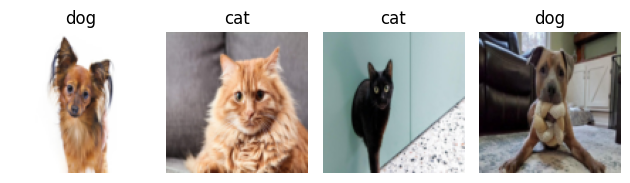

In [ ]:
# Extract features/images and targets/labels
dataset_train = CatDogDataset(annotations_file='annotations_train.csv')
dataset_val = CatDogDataset(annotations_file='annotations_val.csv')

# Create data loaders
dataloader_train = DataLoader(dataset_train, batch_size=1000, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=1000, shuffle=False)
# Extract all data from dataloaders
raw_data_train = next(iter(dataloader_train))
raw_data_val = next(iter(dataloader_val))

# Separate features from targets 
raw_features_train = raw_data_train['image'].numpy()
raw_labels_train = raw_data_train['category'].numpy()
raw_features_val = raw_data_val['image'].numpy()
raw_labels_val = raw_data_val['category'].numpy()
# Uncomment 4 lines below to exam the raw data
# print(f"Raw training features shape: {raw_features_train.shape}, raw trainging labels shape: {raw_labels_train.shape}")
# print(f"Raw validation features shape: {raw_features_val.shape}, raw validation labels shape: {raw_labels_val.shape}")
# print(f"A sample of raw features array:\n {raw_features_train[0]}")
# print(f"First 10 raw training labels: {raw_labels_train[:10]}")

# Visualize a few sample images
fig, axs = plt.subplots(1, 4)
for i in range(4):
    sample_img = raw_features_train[i]
    sample_cls = raw_labels_train[i]
    axs[i] = plt.subplot(1, 4, i + 1)
    axs[i].set_title(f'{"dog" if sample_cls == 1. else "cat"}')
    axs[i].axis('off')
    axs[i].imshow(np.transpose(sample_img, (1, 2, 0)))  # image is already in (H, W, C) format
    plt.tight_layout()

# Rerun this cell to get different samples.

### START CODE HERE ### (≈ 4 lines of code)
features_train = raw_features_train.reshape(raw_features_train.shape[0], -1) / 255.
labels_train = raw_labels_train.reshape(-1, 1)
features_val = raw_features_val.reshape(raw_features_val.shape[0], -1) / 255.
labels_val = raw_labels_val.reshape(-1, 1)
### END CODE HERE ###

# Sanity check
print(f"Processed training features shape: {features_train.shape}, a sample:\n {features_train[0]}")
print(f"Processed training labels shape: {labels_train.shape}")
print(f"Processed test features shape: {features_val.shape}, a sample:\n {features_val[0]}")
print(f"Processed test labels shape: {labels_val.shape}")


**Expected Output**:
>
```console
Processed training features shape: (557, 30000)
Processed training labels shape: (557, 1)
Processed test features shape: (140, 30000)
Processed test labels shape: (140, 1)
```

## 2. Logistic Regression Model
Apply a sigmoid function to transform the output of a linear model within range 0~1. The new model is also called **Logistic Regression Model**.

### $\color{violet}{\textbf{(5\%) Exercise 2: Logistic Regression Model}}$
1. Let the linear model: $\mathbf{Z} = \mathbf{X} \cdot \mathbf{w}^T + b$ to take feature matrix $\mathbf{X}$ as the input and output a transformed/intermediate feature matrix $\mathbf{Z}$.
2. Apply sigmoid function on $\mathbf{Z}$, so that the prediction will be: $\mathbf{\hat{y}} = \sigma(\mathbf{Z}) = 1 / (1 + e^{-\mathbf{Z}})$ 

In [ ]:
def sigmoid(x):
    """ Sigmoid function
    Args:
        x: independent variable, could be an arrary of any shape or a scalar.
    Returns:
        y: dependent variable, could be an arrary of any shape or a scalar.
    """
    ### START CODE HERE ### (≈ 1 line of code)
    y = None
    ### END CODE HERE ###
    return y

def forward(in_features, weight, bias):
    """ Logistic regression model function
    Args:
        in_features: feature matrix, 2d array with shape (# samples, # pixels)
        weight: a row vector with shape (1, # pixels)
        biase: a scalar
    Returns:
        predictions: model predicted values, a column vector or 2d array with shape (# samples, 1)
    """
    ### START CODE HERE ### (≈ 2 lines of code)
    predictions = None
    ### END CODE HERE ###
    return predictions


# Sanity check
np.random.seed(3321)
print(forward(np.random.normal(size=(4, features_test.shape[1])), np.random.normal(0, 0.01, (1, features_test.shape[1])), np.random.normal(0, 0.01)))


**Expected Output**:
>
```console
[[0.78035352]
 [0.68058492]
 [0.60273538]
 [0.41968119]]
```

## 3. Binary Cross Entropy
It is OK to use a Mean Squared Error (MSE) function to compute the model loss. It is better to use a Binary Cross Entropy (BCE) function to assess the model for a binary classification problem. 

$$\mathcal{L}(\mathbf{\hat{y}}, \mathbf{y}) = \frac{1}{M} \Sigma [-\mathbf{y} \log \hat{\mathbf{y}} - (1 - \mathbf{y}) \log(1 - \hat{\mathbf{y}})]$$
### $\color{violet}{\textbf{(5\%) Exercise 3: Cross Entropy Loss}}$


In [ ]:
def bce_loss(predictions, labels):
    """
    Binary Cross Entropy function
        Args:
            predictions: model predicted values, a 2d array with shape (# samples, 1)
            labels: labeled values from data set, a 2d array with shape (# samples, 1)
        Returns:
            loss_value: averaged CE error, a scalar
    """
    ### START CODE HERE ### (≈ 1 line of code)
    loss_value = None
    ### END CODE HERE ###
    return loss_value
    

# Sanity check
np.random.seed(3321)
print(bce_loss(forward(np.random.normal(size=(4, features_test.shape[1])), np.random.normal(0, 0.01, (1, features_test.shape[1])), np.random.normal(0, 0.01)), np.random.randint(0, 2, (4, 1))))

**Expected Output**:
>
```console
0.5250353081044535
```

## 4. Gradient Descent Optimization
### 4.1 Gradient of the Loss
By computing the gradient of the loss, we can figure out what would be the best directions to change the model parameters (weight and bias) so that the loss of the model can be reduced.

$$\frac{\partial \mathcal{L}}{\partial \mathbf{w}} = \begin{bmatrix} \frac{\partial \mathcal{L}}{\partial w_1} & \frac{\partial \mathcal{L}}{\partial w_2} & \dots & \frac{\partial \mathcal{L}}{\partial w_N} \end{bmatrix} = \frac{1}{M} (\hat{\mathbf{y}} - \mathbf{y})^T \cdot \mathbf{X}$$
$$\frac{\partial \mathcal{L}}{\partial b}  = \overline{\hat{\mathbf{y}} - \mathbf{y}} $$

### 4.2 Iterative Gradient Descent
Then by tweaking the model parameters along the gradient a small step (learning rate, $\alpha$) iteratively, we expect to bring the model loss down to a reasonable scale.

- $\text{Initialize } \mathbf{w} \text{ and } b$
- $\text{Repeat until converge}$
    - $\mathbf{w} = \mathbf{w} - \alpha \frac{\partial \mathcal{L}}{\partial \mathbf{w}}$
    - $b = b - \alpha \frac{\partial \mathcal{L}}{\partial b}$
### $\color{violet}{\textbf{(40\%) Exercise 4: Gradient Descent Optimization}}$
1. Define a function to compute gradient of loss
2. Perform gradient descent optimization using appropriate iterations and learning rate.
    1. Initialize weights and bias
    2. Make predictions
    3. Log training loss and test loss
    4. Update weights and bias
    5. Repeat 2 to 5 until converge.
    
**$\color{red}{\textbf{Note: bring training loss below 0.2}}$**



In [ ]:
def grad(predictions, labels, in_features):
    """ Gradient function with sigmoid activation
    Args:
        predictions: model predicted value, a 2d array with shape (# samples, 1)
        labels: labeled value from data set, a 2d array with shape (# samples, 1)
        in_features: feature matrix, a 2d array with shape (# samples, # pixels)
    Returns:
        dw: row vector of BCE loss partial derivatives w.r.t. weights, 2d array with shape (1, # features)
        db: scalar of BCE loss partial derivatives w.r.t. bias
    """
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = None
    db = None
    ### END CODE HERE ### 

    return dw, db

# GD iteration
### START CODE HERE ### (≈ 10 lines of code)
w = None
b = None
num_iters = None
learning_rate = None
losses_train, losses_test = [], []
for i in range(num_iters):
    preds_train = None  # make prediction using model
    loss_train = None  # compute BCE loss using training data
    loss_test = None  # compute BCE loss using test data
    print(f"Iteration {i+1} training loss: {loss_train}, test loss: {loss_test}")
    losses_train.append(loss_train)
    losses_test.append(loss_test)
    dw, db = None  # compute loss gradient
    w = None  # update weight
    b = None  # update bias
### END CODE HERE ### 

plt.plot(range(num_iters), losses_train, 'b--', range(num_iters), losses_test, 'r')

## 5. Model Evaluation
You can treat the model output, $\mathbf{\hat{y}}$ as the probabilities of the images being classified as dog pictures. Set the classification boundary to be 0.5, we can categorize an image as a cat image ($^{(m)}y <= 0.5$) or a dog image ($^{(m)}y > 0.5$). We'll evaluate the model on both training and test dataset.
### $\color{violet}{\textbf{(20\%) Exercise 5: Evaluation on Test Data}}$
Calculate classification accuracy using the trained model.

**$\color{red}{\textbf{Note: model accuracy on training data has to be greater than 0.98}}$**


In [ ]:
# Accuracy on training data
categories_train = preds_train > 0.5  # Convert predictions over 0.5 to 1 (True), otherwise to 0 (False)
is_correct_train = categories_train == labels_train  # Find out which predictions are correct
num_correct_train = np.sum(is_correct_train)  # Calculate how many correct predictions are made
acc_train = num_correct_train / labels_train.shape[0]  # Calculate accuracy rate: # correct predictions / # samples
print(f"Model accuracy on training data: {acc_train}")

### START CODE HERE ### (≈ 5 lines of code)
# Accuracy on test data
preds_test = None  # make predictions on test features
categories_test = None  # Convert predictions over 0.5 to 1 (True), otherwise to 0 (False)
is_correct_test = None  # Find out which predictions are correct
num_correct_test = None  # Calculate how many correct predictions are made
acc_test = None  # Calculate accuracy rate: correct # / total #
### END CODE HERE ###
print(f"Model accuracy on test data: {acc_test}")


> You may notice the big difference bewteen the prediction accuracy on training data vs. test data. What could be the causes of this phenomenon?

## 6. Test
Download new images to this folder and try to use your model to classify them.

### $\color{violet}{\textbf{(10\%) Exercise 6: Test Model with New Image}}$
**$\color{red}{\textbf{Note: you can use two provided pictures to test your code, but please upload at least one new picture for the final test.}}$**


In [ ]:
image_raw = cv.imread('Golden_Retriever.jpg')  # read the raw image from a file
image_rgb = cv.cvtColor(image_raw, cv.COLOR_BGR2RGB)  # Convert BGR to RGB
image_resize = cv.resize(image_rgb, (100, 100))  # Resize image to shape (100, 100, 3)
### START CODE HERE ### (≈ 3 lines of code)
image_flatten = None  # reshape image array to a row vector with shape (1, 100*100*3)
image_rescale = None  # rescale pixel value from 0~255 to 0.~1.
dog_likelihood = None  # predict new image with your model
### END CODE HERE ### 

is_dog = dog_likelihood > 0.5
if is_dog.squeeze():
    print("Woof!") 
else:
    print("Meow!") 


# Congratulations! You have finished this assignment!